# Baseline Code

This code introduces a two-step training for the N-HPatches problem. In N-HPatches problem, we aim to generate a patch descriptor that is able to perform successfully tasks such as matching, retrieval or verification. 

Contrary to classical HPatches dataset, in N-HPatches, images contain random non-smooth perturbations produced by a synthetic noise. This noise could be critical when training the descriptor, therefore, we introduce a denoising model that could help us to deal with those perturbations. Denoising models have been already introduced in the course [tutorials](https://github.com/MatchLab-Imperial/deep-learning-course) and lectures, their objective is to generate a clean/denoised version of the input image.  We will refer in this code to the images with noise as `noisy`, to the images after applying the denoise model as `denoised` and the original patches from HPatches (so no extra noise added) which are used as ground-truth for the denoising step as `clean`. 


Thus, we aim to minimize the noise in images before the second step, which is computing a feature vector, also called descriptor. Those descriptions must be a powerful representation of the input patches. The idea behind is that if two descriptors belong two similar patches, they should be close to each other, i.e. have a low Euclidean distance. See figure below:

![](https://i.ibb.co/4tvm3Vh/descriptorspace.png)

This baseline code gives a method you can use to compare to whatever another approach you develop.  There are several other approaches you can test to see if there is any improvement, e.g. train the descriptor directly with noisy patches, without the denoising model. However, this code provides some guidance about how to implement the different blocks, how to stack them if desired, how to read the data and how to evaluate the method.

The values given can be improved without changing the core method, only by tuning correctly the hyperparameters or giving it more training time, among others.

As a first step of the project, you should get familiar with the problem and the provided code, so you can develop more complex and robust algorithms afterward. 

## Safety Check

As Google Colab is an external platform, we cannot guarantee that everytime you connect to a remote server, you will have the same amount of RAM or video RAM. For that reason, we will first check the amount of memory we have in the notebook. RAM should be around 12.9 GB, which is enough to load the datasets in memory. Also, usually, we have available 11.4 GB of GPU memory, which is more than enough to run this code. However, some users reported having only 500 MB of GPU memory. If you have that amount, restart the environment to see if you get the corresponding 11.4 GB.

In [1]:
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
#!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
#!pip install gputil
#!pip install psutil
#!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

In [2]:
printm()

RAM Free: 29.3 GB  | Proc size: 50.6 MB
GPU RAM Free: 10861MB | Used: 403MB | Util   4% | Total 11264MB


## Downloading Functions and Data

The first step is to clone the GitHub repository of the course, which contains already implemented functions. You can use your own function and import them here doing the same. In addition, we are going to download and extract the N-HPatches data. 

As a note, in colab, we can run terminal commands by using ```!```. Also, by using ```%``` we have access to the [built-in IPython magic commands](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-cd), which we will use to move through directories (`cd` command). It takes around 5 minutes to download and unzip the dataset. 


In [ ]:
# Clone repo
!git clone https://github.com/MatchLab-Imperial/keras_triplet_descriptor

In [3]:
# Change directory
%cd keras_triplet_descriptor    


C:\Users\User\Downloads\keras_triplet_descriptor


In [ ]:
# Download data
!wget -O hpatches_data.zip https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip


In [ ]:
# Extract data
!unzip -q ./hpatches_data.zip
!rm ./hpatches_data.zip

## Importing Necessary Modules

We now import the modules we will use in this baseline code. 

In [4]:
import sys
import json
import os
import glob
import time
import tensorflow as tf
import numpy as np
import cv2
import random

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose
from keras.layers import Input, UpSampling2D, concatenate  

from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet

Using TensorFlow backend.


The `read_data` and `utils` imports are functions provided in the repository we just cloned. You can navigate through the *File tab* and check what those functions do for a better understanding.

![texto del enlace](https://i.ibb.co/HnfSvfT/filetab.png)





We also fix the seeds of the pseudo-random number generators to have reproducible results. The idea of fixing the seed is having the same results every time the algorithm is run if there are no changes in the code.

In [5]:
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

Now we load the data. The original HPatches dataset has several splits, which are used to separate the available sequences in train sequences and test sequences. For our experiments in N-HPatches we use the same splits as in HPatches. Specifically, we load (and report results) using the split `'a'`:


In [6]:
hpatches_dir = './hpatches'
splits_path = 'splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   

In [ ]:
seqs

In [7]:
seqs_train = list(filter(lambda x: x.split('\\')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('\\')[-1] in split['test'], seqs)) 

In [ ]:
len(seqs)

In [ ]:
len(seqs_train)

In [ ]:
len(seqs_test)

## Models and loss

We now define three functions that define the main modules of our baseline. 

*   **get_denoise_model(..)** returns the denoising model. The input for the function is the size of the patch, which will be *1x32x32*, and it outputs a keras denoising model. 
*   **get_descriptor_model(..)** builts the descriptor model. The input for the function is the size of the patch, which will be *1x32x32*, and it outputs a keras descriptor model. The model we use as baseline returns a descriptor of dimension *128x1*.
*   **triplet_loss(..)** defines the loss function which is used to train the descriptor model. 

You can modify the models in these functions and run the training code again. For example, the given denoising model is quite shallow, maybe using a deeper network can improve results. Or testing new initializations for the weights. Or maybe adding dropout. Or modifying the loss function somehow...

In [8]:
def get_denoise_model_optm(activate,shape, do = 0):
  
    inputs = Input(shape)
    
    conv1 = Dropout(do)((Conv2D(32, (3, 3), activation = activate, padding='same')(inputs)))
    conv1 = Dropout(do)((Conv2D(32, (3, 3), activation = activate, padding='same')(conv1)))
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Dropout(do)((Conv2D(64, (3, 3), activation =  activate, padding='same')(pool1)))
    conv2 = Dropout(do)((Conv2D(64, (3, 3), activation =  activate, padding='same')(conv2)))
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Dropout(do)((Conv2D(128, (3, 3), activation =  activate, padding='same')(pool2)))
    conv3 = Dropout(do)((Conv2D(128, (3, 3), activation =  activate, padding='same')(conv3)))
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Dropout(do)((Conv2D(256, (3, 3), activation =  activate, padding='same')(pool3)))
    conv4 = Dropout(do)((Conv2D(256, (3, 3), activation =  activate , padding='same')(conv4)))
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Dropout(do)((Conv2D(512, (3, 3), activation =  activate, padding='same')(pool4)))
    conv5 = Dropout(do)((Conv2D(512, (3, 3), activation =  activate, padding='same')(conv5)))

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Dropout(do)((Conv2D(256, (3, 3), activation =  activate, padding='same')(up6)))
    conv6 = Dropout(do)((Conv2D(256, (3, 3), activation =  activate, padding='same')(conv6)))

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Dropout(do)((Conv2D(128, (3, 3), activation =  activate, padding='same')(up7)))
    conv7 = Dropout(do)((Conv2D(128, (3, 3), activation =  activate, padding='same')(conv7)))

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Dropout(do)((Conv2D(64, (3, 3), activation =  activate, padding='same')(up8)))
    conv8 = Dropout(do)((Conv2D(64, (3, 3), activation =  activate, padding='same')(conv8)))

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Dropout(do)((Conv2D(32, (3, 3), activation =  activate, padding='same')(up9)))
    conv9 = Dropout(do)((Conv2D(32, (3, 3), activation =  activate, padding='same')(conv9)))

    conv10 = Dropout(do)(Conv2D(1, (1, 1))(conv9))

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

def get_denoise_model_modified(activate,shape, do = 0):
  
    inputs = Input(shape)
    
    conv1 = Dropout(do)((Conv2D(32, (3, 3), activation = activate, padding='same')(inputs)))
    conv1 = Dropout(do)((Conv2D(32, (3, 3), activation = activate, padding='same')(conv1)))
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Dropout(do)((Conv2D(64, (3, 3), activation =  activate, padding='same')(pool1)))
    conv2 = Dropout(do)((Conv2D(64, (3, 3), activation =  activate, padding='same')(conv2)))
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Dropout(do)((Conv2D(128, (3, 3), activation =  activate, padding='same')(pool2)))
    conv3 = Dropout(do)((Conv2D(128, (3, 3), activation =  activate, padding='same')(conv3)))
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Dropout(do)((Conv2D(256, (3, 3), activation =  activate, padding='same')(pool3)))
    conv4 = Dropout(do)((Conv2D(256, (3, 3), activation =  activate , padding='same')(conv4)))
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Dropout(do)((Conv2D(512, (3, 3), activation =  activate, padding='same')(pool4)))
    conv5 = (Conv2D(512, (3, 3), activation =  activate, padding='same'))(UpSampling2D(size = (2,2))(conv5))

    up6 = concatenate([conv5, conv4], axis=3)
    conv6 = Dropout(do)((Conv2D(256, (3, 3), activation =  activate, padding='same')(up6)))
    conv6 = (Conv2D(256, (3, 3), activation =  activate, padding='same'))(UpSampling2D(size = (2,2))(conv6))

    up7 = concatenate([conv6, conv3], axis=3)
    conv7 = Dropout(do)((Conv2D(128, (3, 3), activation =  activate, padding='same')(up7)))
    conv7 = (Conv2D(128, (3, 3), activation =  activate, padding='same'))(UpSampling2D(size = (2,2))(conv7))

    up8 = concatenate([conv7, conv2], axis=3)
    conv8 = Dropout(do)((Conv2D(64, (3, 3), activation =  activate, padding='same')(up8)))
    conv8 = (Conv2D(64, (3, 3), activation =  activate, padding='same'))(UpSampling2D(size = (2,2))(conv8))

    up9 = concatenate([conv8, conv1], axis=3)
    conv9 = Dropout(do)((Conv2D(32, (3, 3), activation =  activate, padding='same')(up9)))
    conv9 = Dropout(do)((Conv2D(32, (3, 3), activation =  activate, padding='same')(conv9)))

    conv10 = Dropout(do)(Conv2D(1, (1, 1))(conv9))

    model = Model(inputs=[inputs], outputs=[conv10])

    return model


def get_descriptor_model(shape):
  
    '''Architecture copies HardNet architecture'''

    init_weights = keras.initializers.he_normal()

    descriptor_model = Sequential()
    descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))

    descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
    descriptor_model.add(BatchNormalization(axis = -1))
    descriptor_model.add(Activation('relu'))
    descriptor_model.add(Dropout(0.3))

    descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))

    # Final descriptor reshape
    descriptor_model.add(Reshape((128,)))

    return descriptor_model
  

def triplet_loss(x):
  
    output_dim = 128
    a, p, n = x
    _alpha = 1.0
    positive_distance = K.mean(K.square(a - p), axis=-1)
    negative_distance = K.mean(K.square(a - n), axis=-1)

    return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)

## Denoising Image Patches


We use the *DenoiseHPatches* class implemented in the read_data.py file, which takes as input the list of sequences to load and the size of batches. 

*DenoiseHPatches* outputs batches where the input data is the noisy image and the label is the clean image, so we can use a mean absolute error (MAE) metric as loss function. You can try to use different metrics here to see if that improves results. 

Afterward, we take a subset of training and validation sequences by using *random.sample* (3 sequences for training and 1 for validation data). The purpose of doing so is just to speed-up training when trying different setups, but you should use the whole dataset when training your final model. Remove the random.sample function to give the generator all the training data.

In addition, note that we are using the test set as validation. We will provide you with a new test set that will be used to evaluate your final model, and from which you will not have the clean images. 

**Updated**: Training should be quite faster now (1 epoch around 15 minutes).

In [9]:
#denoise_generator = DenoiseHPatches(random.sample(seqs_train, 5), batch_size=50)
#denoise_generator_val = DenoiseHPatches(random.sample(seqs_test, 1), batch_size=50)

# Uncomment following lines for using all the data to train the denoising model
denoise_generator = DenoiseHPatches(seqs_train, batch_size=50)
denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=50)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:31<00:00,  1.41it/s]


In [10]:
from keras.layers import LeakyReLU
shape = (32, 32, 1)
denoise_model_optm = get_denoise_model_optm('selu', shape)
denoise_model_modified = get_denoise_model_modified('selu', shape)

Instructions for updating:
Colocations handled automatically by placer.


We set number of epochs to 1, tweak it, along with other hyperparameters, to improve the performance of the model.

In [ ]:
adam = keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

denoise_model_optm.compile(loss='mean_absolute_error', optimizer=adam, metrics=['mae'])
denoise_model_modified.compile(loss='mean_absolute_error', optimizer=adam, metrics=['mae'])


#epochs = 1
### Use a loop to save for each epoch the weights in an external website in
### case colab stops. Every time you call fit/fit_generator the weigths are NOT
### reset, so e.g. calling 5 times fit(epochs=1) behave as fit(epochs=5)
#for e in range(epochs):
denoise_history_optm = denoise_model_optm.fit_generator(generator=denoise_generator, 
                                            epochs=10, verbose=1, 
                                            validation_data=denoise_generator_val)
denoise_model_optm.save('denoise_optm.h5') 

denoise_history_modified = denoise_model_modified.fit_generator(generator=denoise_generator, 
                                            epochs=10, verbose=1, 
                                            validation_data=denoise_generator_val)
denoise_model_modified.save('denoise_modified.h5') 
### Saves optimizer and weights


### Uploads files to external hosting
#!curl -F "file=@denoise.h5" https://file.io


In [ ]:
del denoise_generator
del denoise_generator_val

After every epoch, the code will generate an external link, this link saves your weights in case of colab disconnecting during training. Example of an epoch:

**Epoch 1/1**
1797/1797 [==============================] - 48s 27ms/step - loss: 11.4135 - 
mean_absolute_error: 11.4135 - val_loss: 7.6013 - val_mean_absolute_error: 7.6013 
{"success":true,"key":"fv9vjj"

"link":"https://file.io/fv9vjj","expiry":"14 days"} **Epoch 1/1**

If colab did not disconnect, and you want to save the weights in your local disk, you also can use:


In [ ]:
#from google.colab import files
#files.download('denoise.h5')

Moreover, if you have a model saved from a previous training session, you can upload it to colab and initialize the model's weights with it. 

You either can use `!wget download_link` or upload the weights from your local disk by using the left panel ('Files' section) in colab.

Once the weights are uploaded, you can use

> ``denoise_model = keras.models.load_model('./denoise.h5')
``

to load the weights.

### Visualization of Denoising Results
To visualize how the denoised patches look, you can run the following function. It returns the noisy patch, the denoised patch in the middle, and the clean patch in the right side. 

In [14]:
import matplotlib.pyplot as plt

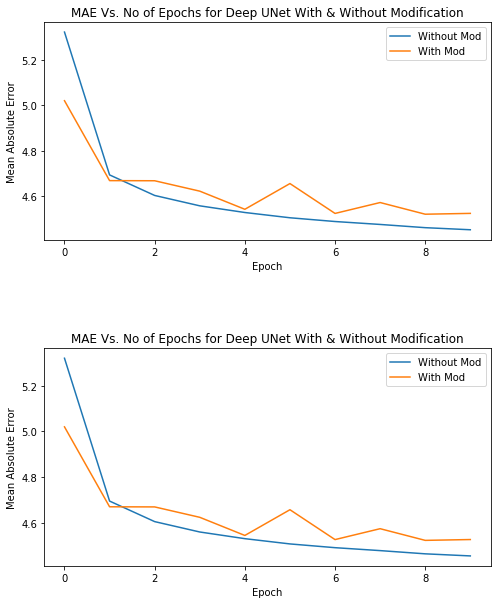

In [17]:
def plot_history(history, history2, metric = None):
  # Plots the loss history of training and validation (if existing)
  # and a given metric
  
  if metric != None:
    fig, axes = plt.subplots(2,1, figsize=(8, 10))
    axes[0].plot(history.history[metric])
    axes[0].plot(history2.history[metric])
    #axes[0].plot(history3.history[metric])
    #axes[0].plot(history4.history[metric])
    #axes[0].plot(history5.history[metric])
    #axes[0].plot(history6.history[metric])
    try:
      #axes[0].plot(history.history['val_'+metric])
      #axes[0].plot(history2.history['val2_'+metric])
      #axes[0].plot(history3.history['val3_'+metric])
      axes[0].legend(['Without Mod', 'With Mod'], loc='upper right')
    except:
      pass
    axes[0].set_title('MAE Vs. No of Epochs for Deep UNet With & Without Modification')
    axes[0].set_ylabel('Mean Absolute Error')
    axes[0].set_xlabel('Epoch')
    fig.subplots_adjust(hspace=0.5)
    axes[1].plot(history.history['loss'])
    axes[1].plot(history2.history['loss'])
    #axes[1].plot(history3.history['loss'])
    #axes[1].plot(history4.history['loss'])
    #axes[1].plot(history5.history['loss'])
    #axes[1].plot(history6.history['loss'])
    try:
      #axes[1].plot(history.history['val_loss'])
      axes[1].legend(['Without Mod', 'With Mod'], loc='upper right')
    except:
      pass
    axes[1].set_title('MAE Vs. No of Epochs for Deep UNet With & Without Modification')
    axes[1].set_ylabel('Mean Absolute Error')
    axes[1].set_xlabel('Epoch')
  else:
    plt.plot(history.history['loss'])
    try:
      plt.plot(history.history['val_loss'])
      plt.legend(['Train', 'Val'])
    except:
      pass
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
  
plot_history(denoise_history_optm, denoise_history_modified, 'mean_absolute_error')

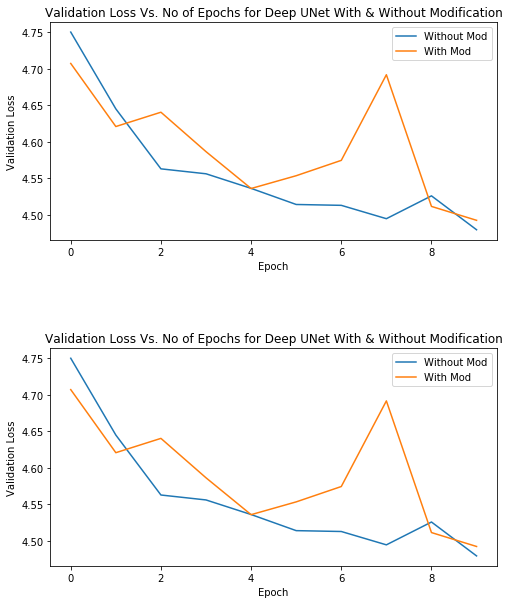

In [18]:
def plot_val_history(history, history2, metric = None):
  # Plots the loss history of training and validation (if existing)
  # and a given metric
  
  if metric != None:
    fig, axes = plt.subplots(2,1, figsize=(8, 10))
    #axes[0].plot(history.history[metric])
    #axes[0].plot(history2.history[metric])
    #axes[0].plot(history3.history[metric])
    try:
      axes[0].plot(history.history['val_'+metric])
      axes[0].plot(history2.history['val_'+metric])
      #axes[0].plot(history3.history['val_'+metric])
      #axes[0].plot(history4.history['val_'+metric])
      #axes[0].plot(history5.history['val_'+metric])
      #axes[0].plot(history6.history['val_'+metric])
      axes[0].legend(['Without Mod', 'With Mod'], loc='upper right')

    except:
      pass
    axes[0].set_title('Validation Loss Vs. No of Epochs for Deep UNet With & Without Modification')
    axes[0].set_ylabel('Validation Loss')
    axes[0].set_xlabel('Epoch')
    fig.subplots_adjust(hspace=0.5)
    #axes[1].plot(history.history['loss'])
    #axes[1].plot(history2.history['loss'])
    #axes[1].plot(history3.history['loss'])
    try:
      axes[1].plot(history.history['val_loss'])
      axes[1].plot(history2.history['val_loss'])
      #axes[1].plot(history3.history['val_loss'])
      #axes[1].plot(history4.history['val_loss'])
      #axes[1].plot(history5.history['val_loss'])
      #axes[1].plot(history6.history['val_loss'])
      axes[1].legend(['Without Mod', 'With Mod'], loc='upper right')

    except:
      pass
    axes[1].set_title('Validation Loss Vs. No of Epochs for Deep UNet With & Without Modification')
    axes[1].set_ylabel('Validation Loss')
    axes[1].set_xlabel('Epoch')
  else:
    plt.plot(history.history['loss'])
    try:
      plt.plot(history.history['val_loss'])
      plt.legend(['Train', 'Val'])
    except:
      pass
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
  
plot_val_history(denoise_history_optm, denoise_history_modified,'mean_absolute_error')